In [1]:
from Vocabulary import *
from DataLoader import *
from Model import *
from nltk.tokenize import WordPunctTokenizer
from nltk import bleu_score
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from random import shuffle
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import tensorflowjs as tfjs
%matplotlib inline

In [2]:
if not os.path.exists('files'):
    os.makedirs('files')

In [3]:
src = []
dst = []
with open('data/train.tags.de-en.de') as f:
    src = list(map(lambda x: x.lower(), f.read().split('\n')))[1:]
with open('data/train.tags.de-en.en') as f:
    dst = list(map(lambda x: x.lower(), f.read().split('\n')))[1:]

In [4]:
tokenizer = WordPunctTokenizer()
src = list(map(lambda x: ' '.join(tokenizer.tokenize(x)), src))
dst = list(map(lambda x: ' '.join(tokenizer.tokenize(x)), dst))

In [5]:
with open('files/src.txt', 'w') as f:
    f.write('\n'.join(src))
with open('files/dst.txt', 'w') as f:
    f.write('\n'.join(dst))

In [6]:
with open('files/src.txt', 'r') as f_in, open('files/bpe_src.rules', 'w') as f_out:
    learn_bpe(f_in, f_out, num_symbols=4000, verbose=False)
with open('files/dst.txt', 'r') as f_in, open('files/bpe_dst.rules', 'w') as f_out:
    learn_bpe(f_in, f_out, num_symbols=4000, verbose=False)

In [7]:
with open('files/bpe_src.rules') as f:
    bpe_src = BPE(f, separator='~@~@')
with open('files/bpe_dst.rules') as f:
    bpe_dst = BPE(f, separator='~@~@')

In [8]:
src = list(map(lambda x: ' '.join(bpe_src.segment(x).split(' ')), src))
dst = list(map(lambda x: ' '.join(bpe_dst.segment(x).split(' ')), dst))

In [9]:
voc_src = Voc(src)
voc_dst = Voc(dst)

In [10]:
src_dst = list(map(lambda x: (src[x], dst[x]), range(len(src))))
loader = DataLoader(src_dst, voc_src, voc_dst)

In [11]:
EMB_SIZE = 128
HID_SIZE = 512
enc = get_encoder(voc_src, EMB_SIZE, HID_SIZE)
dec = get_decoder_step(voc_dst, EMB_SIZE, HID_SIZE)

In [ ]:
enc.load_weights('files/enc.weights')
dec.load_weights('files/dec.weights')

In [12]:
trainable_weights = enc.trainable_weights + dec.trainable_weights
optimizer = tf.optimizers.Adam()

In [13]:
def train_on_batch(x, y):
    """
    Compute mean crossentropy over all time-steps, perform gradient descent
    :param x: input tokens, tensor of int32[batch_size, input_length]
    :param y: output tokens, tensor of int32[batch_size, output_length]
    :returns: mean loss funtion
    """
    
    with tf.GradientTape() as tape:
        tape.watch(trainable_weights)
        
        losses = []
        states = enc(x)
        res = tf.zeros([x.shape[0], HID_SIZE])
        for i in range(y.shape[1] - 1):
            res, prob, state_probs = dec([y[:, i], res, states])
            losses.append(tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y[:, i + 1], prob)))

        mean_loss = sum(losses) / len(losses)
        
    gradients = tape.gradient(mean_loss, trainable_weights)
    optimizer.apply_gradients([(gradients[i], trainable_weights[i]) for i in range(len(gradients))])
    return float(mean_loss)

In [14]:
def predict_by_states(states, symbols=10, until_eos=False):
    state = tf.zeros([states.shape[0], HID_SIZE])
    tokens = tf.convert_to_tensor([voc_dst.token_to_num['_BOS_']])
    str_res = ''
    if until_eos:
        while True:
            state, next_probs, state_probs = dec([tokens, state, states])
            tokens = tf.argmax(next_probs, axis=-1)
            if str(voc_dst.num_to_token[int(tokens[0])]) == '_EOS_':
                break
            str_res += str(voc_dst.num_to_token[int(tokens[0])]) + ' '
    else:
        for i in range(symbols):
            state, next_probs, state_probs = dec([tokens, state, states])
            tokens = tf.argmax(next_probs, axis=-1)
            if str(voc_dst.num_to_token[int(tokens[0])]) == '_EOS_':
                break
            str_res += str(voc_dst.num_to_token[int(tokens[0])]) + ' '
    if len(str_res) > 0:
        return str_res[:-1]
    return str_res

In [15]:
def predict_random(symbols=10, until_eos=False):
    x_batch, y_batch = loader.get_train_batch(1)
    print('SOURCE:')
    print(voc_src.tensor_to_strings(x_batch)[0])
    print('REFERENCE:')
    print(voc_dst.tensor_to_strings(y_batch)[0])
    print('PREDICTION:')
    states = enc(x_batch)
    print(predict_by_states(states, symbols=symbols, until_eos=until_eos))

In [16]:
def predict_by_string(string, symbols=10, until_eos=False):
    string = ' '.join(tokenizer.tokenize(string.lower()))
    string = bpe_src.segment(string)
    x = voc_src.strings_to_tensor([string])
    states = enc(x)
    print(predict_by_states(states, symbols=symbols, until_eos=until_eos))

In [17]:
def accuracy_on_test(iterations=5000):
    references = []
    translations = []
    for i in range(iterations):
        x, y = loader.get_test_batch(1)
        references.append(voc_dst.tensor_to_strings(y)[0])
        states = enc(x)
        translations.append(predict_by_states(states, symbols=y.shape[1] * 2))
    return bleu_score.corpus_bleu([[ref] for ref in references], translations)

In [18]:
def train(batch_size, iterations, interval_of_saving_losses=0, interval_of_saving_weights=0,
          show_losses=False, show_traslation=False):
    batch_losses = []
    for i in range(iterations):
        x_batch, y_batch = loader.get_train_batch(batch_size)
        loss = train_on_batch(x_batch, y_batch)
        batch_losses.append(loss)
    
        if show_losses:
            clear_output(True)
            plt.plot(batch_losses)
            plt.show()
            
        if interval_of_saving_losses != 0:
            if i % interval_of_saving_losses == 0:
                plt.plot(batch_losses)
                plt.savefig('files/losses.png')
                plt.clf()
            
        if i % 100 == 0 and show_traslation:
            predict_random()
        
        if interval_of_saving_weights != 0:
            if i % interval_of_saving_weights == 0:
                enc.save_weights('files/enc.weights')
                dec.save_weights('files/dec.weights')

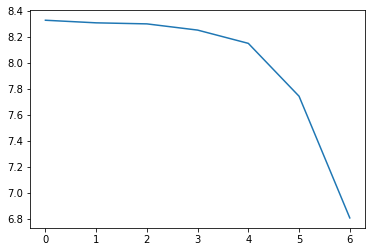

In [ ]:
try:
    train(32, 1000000000, interval_of_saving_losses=1000, interval_of_saving_weights=1000, show_losses=True)
except Exception as e:
    open('files/exeptions.txt', 'w').write(repr(e))

In [79]:
accuracy_on_test(500)

0.5762750370209755

In [69]:
predict_random()

SOURCE:
mit generation 10 geht er schon ein paar schritte weiter – noch nicht ganz perfe~@~@ kt .
REFERENCE:
generation 10 and it ' ll take a few steps more -- still not quite there .
PREDICTION:
, , ,


In [25]:
tfjs.converters.save_keras_model(enc, 'files/enc')
tfjs.converters.save_keras_model(dec, 'files/dec')

In [21]:
import json
with open('files/voc.json', 'w') as f:
    packed_bpe_rules_src = list(map(list, sorted(bpe_src.bpe_codes.keys(), key=bpe_src.bpe_codes.get)))
    packed_bpe_rules_dst = list(map(list, sorted(bpe_dst.bpe_codes.keys(), key=bpe_dst.bpe_codes.get)))
    token_to_num_src = voc_src.token_to_num
    token_to_num_dst = voc_dst.token_to_num
    num_to_token_dst = voc_src.num_to_token
    json.dump([packed_bpe_rules_src, packed_bpe_rules_dst, token_to_num_src, token_to_num_dst,
               num_to_token_dst, '~@~@', '_EOS_', '</w>', HID_SIZE], f)